In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import random

In [13]:
# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')

def moving_average(interval, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(interval, window, 'valid')

def plot_profitability(trial_id):
    prices_fname = trial_id + '_strats.csv'
    times_list = []
    buyer_pss_list = []
    seller_pps_list = []
    total_pps_list = []
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = int(row[1])
            # print(row)
            buyer_pps = 0
            seller_pps = 0
            for i in range(2, len(row) - 13, 7):
                if row[i + 1][0] == 'B':
                    buyer_pps += float(row[i + 6])
                elif row[i + 1][0] == 'S':
                    seller_pps += float(row[i + 6])
            times_list.append(time / 60 / 60 / 24)
            buyer_pss_list.append(buyer_pps)
            seller_pps_list.append(seller_pps)
            total_pps_list.append(buyer_pps + seller_pps)
    plt.scatter(times_list, buyer_pss_list, marker = 'x', s = 0.1)
    plt.scatter(times_list, seller_pps_list, marker = 'x', s = 0.1)
    plt.scatter(times_list, total_pps_list, marker = 'x', s = 0.1)
    ma_length = 24
    start = ma_length // 2 - 1
    end = -1 * start - 1
    plt.plot(times_list[start:end], moving_average(buyer_pss_list, ma_length))
    plt.plot(times_list[start:end], moving_average(seller_pps_list, ma_length))
    plt.plot(times_list[start:end], moving_average(total_pps_list, ma_length))
    print(np.mean(total_pps_list))
    # plt.plot(times_list, moving_average(buyer_pss_list, 20))
    # plt.plot(times_list, moving_average(seller_pps_list, 20))
    # plt.plot(times_list, moving_average(total_pps_list, 20))
    

k=4,F=0.8
169.32729694999998


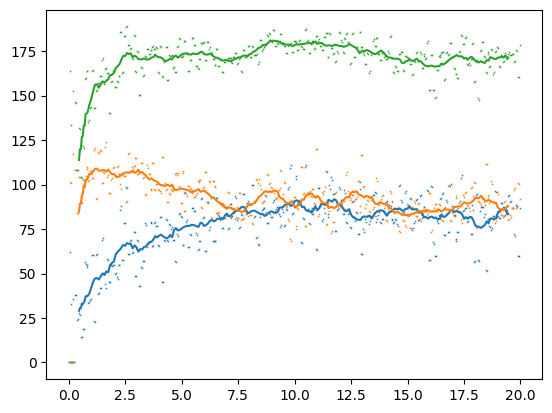

k=4,F=0
148.28089638125002


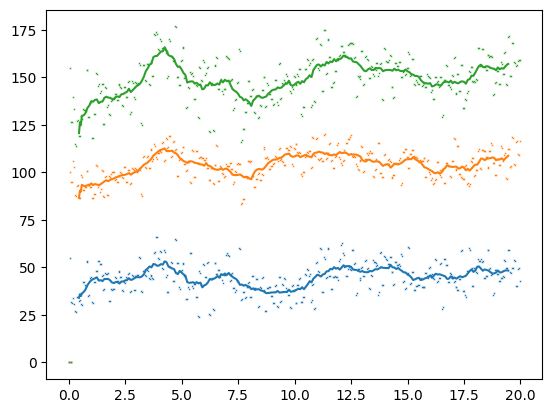

k=4,F=2
166.75888391875003


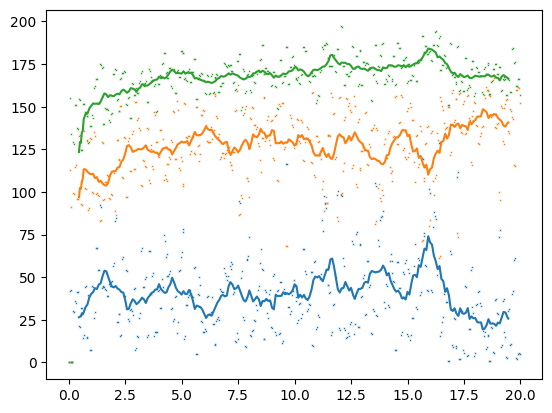

k=50,F=0.8
144.48917882291664


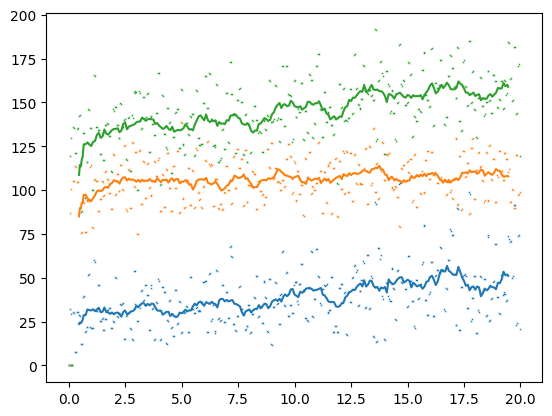

In [17]:
print(trial_id := "k=4,F=0.8")
plot_profitability(trial_id)
plt.show()

print(trial_id := "k=4,F=0")
plot_profitability(trial_id)
plt.show()

print(trial_id := "k=4,F=2")
plot_profitability(trial_id)
plt.show()

print(trial_id := "k=50,F=0.8")
plot_profitability(trial_id)
plt.show()

print(trial_id := "k=50,F=0.9")
plot_profitability(trial_id)
plt.show()